In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [57]:
sns.set()
%matplotlib inline

In [58]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
%autoreload 2

In [60]:
from sir_models.seir import SEIR

# Load data

In [61]:
df = pd.read_csv('data/data.csv', sep=';')

In [62]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [63]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [64]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


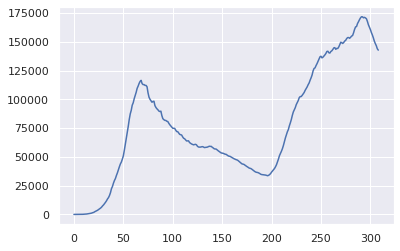

In [65]:
df['infected'].plot()

In [66]:
df_smoothed = df.drop(columns=['region']).rolling(7).mean()
df_smoothed['date'] = df['date']
df_smoothed.head(10)

,index,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-13
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-14
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-15
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-16
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-17
6,286.285714,44.428571,0.571429,0.0,0.0,12.285714,0.142857,43.857143,2020-03-18
7,369.000000,55.428571,0.714286,0.0,0.0,11.000000,0.142857,54.714286,2020-03-19
8,452.142857,70.428571,1.428571,0.0,0.0,15.000000,0.714286,69.000000,2020-03-20
9,535.714286,85.000000,2.571429,0.0,0.0,14.571429,1.142857,82.428571,2020-03-21


Text(0.5, 1.0, 'Active infected')

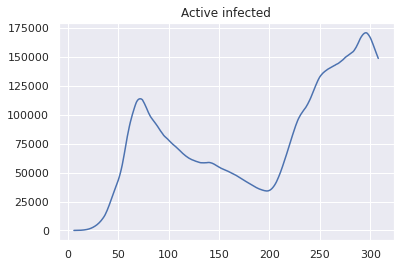

In [67]:
df_smoothed.infected.plot()
plt.title('Active infected')

Text(0.5, 1.0, 'Total infected')

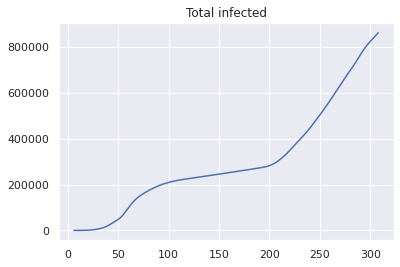

In [68]:
df_smoothed.total_infected.plot()
plt.title('Total infected')

Text(0.5, 1.0, 'Total dead')

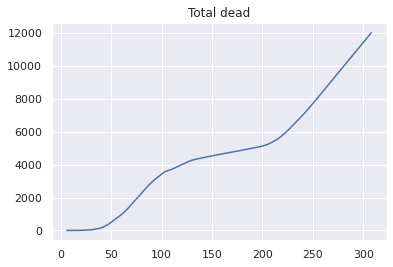

In [69]:
df_smoothed.total_dead.plot()
plt.title('Total dead')

In [70]:
df = df_smoothed.dropna().reset_index(drop=True)

### Modelling infection fear and quarantine measures

[]

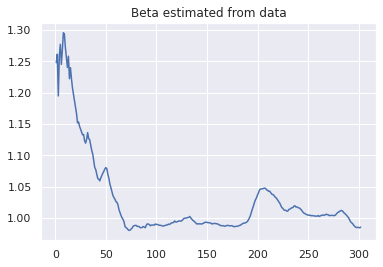

In [71]:
beta_from_data = df['infected'] / df['infected'].shift(1)
beta_from_data.plot()
plt.title('Beta estimated from data')
plt.plot()

In [72]:
beta_base = beta_from_data.max()
beta_base

1.2952836637047165

Text(0.5, 1.0, 'Infection "fear"')

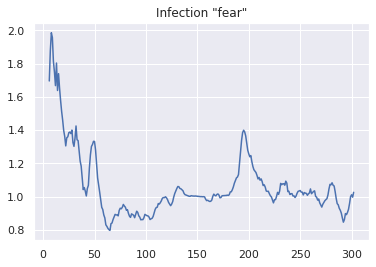

In [73]:
fear = df['infected_per_day']/df['infected_per_day'].rolling(7).mean()
plt.plot(fear)
plt.title('Infection "fear"')

[]

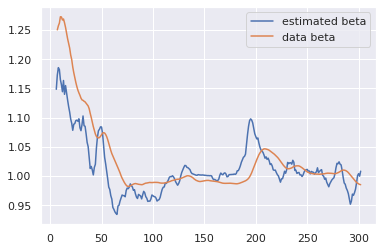

In [74]:
beta_fear = beta_base - 0.8 * 1/np.exp(fear)
plt.plot(beta_fear, label='estimated beta')
beta_from_data.rolling(7).mean().plot(label='data beta')
plt.legend()
plt.plot()

In [75]:
beta_fear

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
298    0.988481
299    1.000923
300    1.004204
301    0.999954
302    1.008494
Name: infected_per_day, Length: 303, dtype: float64

In [76]:
beta_fear[50], beta_from_data[50]

(1.084046080527815, 1.0804544438441908)

# Set global params

In [77]:
population = 12_000_000

# SEIR full

In [79]:
model = SEIR(population)
subset = df[20:]
model.fit(subset)

S, E, I, R, D = model.predict_train()

result = model.fit_result_
R0 = result.params['beta']/result.params['gamma']
R0

0.5496912668419216

In [80]:
subset.iloc[0]

index                               1979
total_infected                   3456.14
total_recovered                  177.571
total_dead                       24.4286
deaths_per_day                   2.85714
infected_per_day                 509.714
recovered_per_day                21.7143
infected                         3254.14
date                 2020-04-07 00:00:00
Name: 20, dtype: object

In [81]:
subset.iloc[-1]

index                              25949
total_infected                    862538
total_recovered                   701744
total_dead                       12022.6
deaths_per_day                   73.2857
infected_per_day                 4857.57
recovered_per_day                6970.71
infected                          148771
date                 2021-01-14 00:00:00
Name: 302, dtype: object

In [82]:
result

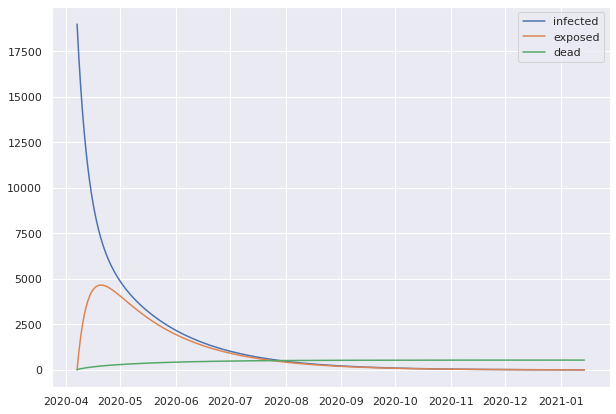

In [83]:
plt.figure(figsize=(10, 7))
plt.plot(subset.date, I, label='infected')
plt.plot(subset.date, E, label='exposed')
#plt.plot(subset.date, R, label='recovered')
plt.plot(subset.date, D, label='dead')
plt.legend()
plt.show()

In [84]:
result

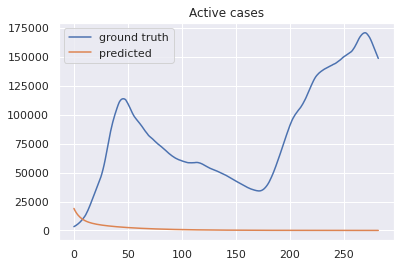

In [85]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

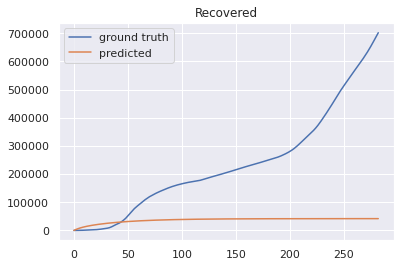

In [86]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

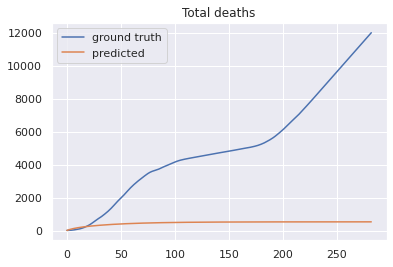

In [87]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

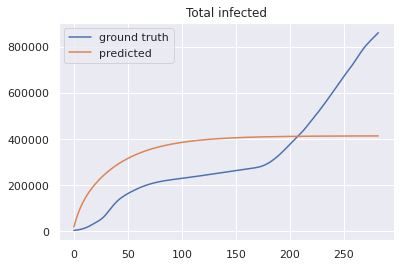

In [88]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()